In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
import json
from collections import Counter
import random
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


NHTS:

Data from a total of 129,696 households (264,234 people, 923,572 trips) were included in the 2017 NHTS dataset.

It documents daily household travel.


*   DBPPOPDN:	Category of population density (persons per square mile) in the 
census block group of the trip destination's location
*   OBPPOPDN:	Category of population density (persons per square mile) in the census block group of the trip origin's location
*   DISTTOSC17: 	Road network distance, in miles, between respondent's home location and school location
*   HH_CBSA: Core Based Statistical Area (CBSA) FIPS code for the respondent's home address (14460	Boston-Cambridge-Newton, MA-NH)
*   HHSTATE:	Household state
*   SCHTRN1:	Mode to school
*   SCHTRN2:	Mode from school
*  TRPMILES:	Trip distance in miles, derived from route geometry returned by Google Maps API, or from reported loop-trip distance
*   TRPTRANS:	Trip Mode, derived
*  TRVLCMIN:	Trip Duration in Minutes
*   WALK_DEF:	Reason for Not Walking More: Infrastructure
*   WALK_GKQ:	Reason for Not Walking More: Safety
*   WHYTO:	Trip Destination Purpose
*   DBHUR:	Urban / Rural indicator - Trip Destination Block group (trippub)
*   OBHUR:	Urban / Rural indicator - Trip Origin Block group (trippub)


# Import data

In [ ]:
#Import household info
hhpub = pd.read_csv ('drive/MyDrive/Amenities/data/NHTS/Copy of hhpub.csv', index_col = False)
hhpub.head(2)

,HOUSEID,TRAVDAY,SAMPSTRAT,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,PC,SPHONE,TAB,...,SMPLSRCE,WTHHFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,2,3,1,3,5,7,2,1,2,...,2,187.314320,T,50,1500,750,750,20,750,300
1,30000008,5,2,1,2,4,8,1,1,2,...,2,69.513032,R,5,300,300,150,5,300,300


In [ ]:
#Import trip info
trippub = pd.read_csv ('drive/MyDrive/Amenities/data/NHTS/Copy of trippub.csv', index_col = False)
trippub.head(2)

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300


In [ ]:
#Import household info
perpub = pd.read_csv ('drive/MyDrive/Amenities/data/NHTS/Copy of perpub.csv', index_col = False)
perpub.head(2)

,HOUSEID,PERSONID,R_AGE,EDUC,R_HISP,R_RELAT,R_SEX,R_RACE,PRMACT,PAYPROF,...,SMPLSRCE,WTPERFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,1,67,3,2,1,2,2,6,2,...,2,206.690153,T,50,1500,750,750,20,750,300
1,30000007,2,66,3,2,2,1,2,1,-1,...,2,197.075742,T,50,1500,750,750,20,750,300


In [ ]:
#Import household info
vehpub = pd.read_csv ('drive/MyDrive/Amenities/data/NHTS/Copy of vehpub.csv', index_col = False)
vehpub.head(2)

,HOUSEID,VEHID,VEHYEAR,VEHAGE,MAKE,MODEL,FUELTYPE,VEHTYPE,WHOMAIN,OD_READ,...,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN,GSYRGAL,GSTOTCST,FEGEMPG,FEGEMPGA,GSCOST,FEGEMPGF
0,30000007,1,2007,10,49,49032,1,1,3,69000,...,750,20,750,300,487.064221,1126.457778,30,-9,2.31275,1
1,30000007,2,2004,13,49,49442,1,2,-8,164000,...,750,20,750,300,250.899523,580.267873,19,-9,2.31275,1


# Frequency analysis

In [ ]:
trips=trippub[['HOUSEID', 'PERSONID', 'DBPPOPDN', 'OBPPOPDN', 'DBHUR', 'OBHUR', 'HHSTATE', 'TRPMILES', 'TRPTRANS', 'TRVLCMIN', 'WHYTO', 'TRPACCMP', 'TRPHHACC']]
trips.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC
0,30000007,1,300,750,T,T,NC,5.244,3,15,19,0,0
1,30000007,1,750,300,T,T,NC,5.149,3,20,1,0,0


In [ ]:
len(trips)

923572

In [ ]:
#Keep the trips whose origin has a high population density
pop_dens=([17000, 30000])
trips = trips[trips['OBPPOPDN'].isin(pop_dens)].reset_index().drop('index', axis = 1)
trips = trips[trips['DBPPOPDN'].isin(pop_dens)].reset_index().drop('index', axis = 1)
trips.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC
0,30000082,2,17000,17000,U,U,NY,0.239,1,5,4,12,0
1,30000082,2,17000,17000,U,U,NY,0.267,1,11,7,1,0


In [ ]:
len(trips)

28609

In [ ]:
trips['DBPPOPDN'].unique()

array([17000, 30000])

In [ ]:
#Import TRPTRANS and WHYTO meaning
trptrans_code = pd.read_csv ('drive/MyDrive/Amenities/data/NHTS/Copy of TRPTRANS_code.csv', index_col = False)
whyto_code = pd.read_csv ('drive/MyDrive/Amenities/data/NHTS/Copy of WHYTO_code.csv', index_col = False)
#Merge trips in BGA (saturday) with safegraph data
trips = trips.merge(trptrans_code[['TRPTRANS', 'transport_mode']], on='TRPTRANS', how = 'left')
trips = trips.merge(whyto_code[['WHYTO', 'travel_purpose']], on='WHYTO', how = 'left')
trips.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose
0,30000082,2,17000,17000,U,U,NY,0.239,1,5,4,12,0,Walk,Work
1,30000082,2,17000,17000,U,U,NY,0.267,1,11,7,1,0,Walk,Change type of transportation


In [ ]:
#We delete trips with travel purpose = prefer not to answer, don't know...and volunteering, visits, drop off/pick up someone
list_whyto=([-7, -8, -9, 97, 1, 5, 6, 7, 17])
trips.drop(trips.loc[trips['WHYTO'].isin(list_whyto)].index, inplace=True)
trips.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose
0,30000082,2,17000,17000,U,U,NY,0.239,1,5,4,12,0,Walk,Work
2,30000085,1,30000,30000,U,U,CA,0.251,1,5,3,0,0,Walk,Work


In [ ]:
#We delete trips with transport_mode = prefer not to answer, don't know...and water transport, paratransit, motorcycle, airplane
list_trptrans=([-7, -8, -9, 7, 8, 12, 19, 20, 97])
trips.drop(trips.loc[trips['TRPTRANS'].isin(list_trptrans)].index, inplace=True)
trips.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose
0,30000082,2,17000,17000,U,U,NY,0.239,1,5,4,12,0,Walk,Work
2,30000085,1,30000,30000,U,U,CA,0.251,1,5,3,0,0,Walk,Work


In [ ]:
len(trips)

15285

In [ ]:
#Merge HOUSEID and PERSONID
trips['person_id'] = trips['HOUSEID'].astype(str) + trips['PERSONID'].astype(str)
trips.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose,person_id
0,30000082,2,17000,17000,U,U,NY,0.239,1,5,4,12,0,Walk,Work,300000822
2,30000085,1,30000,30000,U,U,CA,0.251,1,5,3,0,0,Walk,Work,300000851


In [ ]:
#Count number of trips to each travel purpose
count_purpose = trips.groupby(['travel_purpose']).agg({'person_id': 'count'}).reset_index().rename(columns = {'person_id': 'n_visits'})
count_purpose.head(2)

,travel_purpose,n_visits
0,Errands,745
1,Exercise,1249


In [ ]:
count_people=trips['person_id'].nunique()

In [ ]:
NHTS_frequency_analysis=count_purpose.copy()
NHTS_frequency_analysis['n_visits']=NHTS_frequency_analysis['n_visits']*7*52/12 #Multiply n_visits/day by 7--> n_visits/week, multiply it by 52-->n_visits/year. Divide it by 12 months-->n_visits/month
NHTS_frequency_analysis['frequency']=NHTS_frequency_analysis['n_visits']/count_people
NHTS_frequency_analysis.head(10)

,travel_purpose,n_visits,frequency
0,Errands,22598.333333,2.601397
1,Exercise,37886.333333,4.361268
2,F&B Eatery,85388.333333,9.829439
3,Healthcare,13498.333333,1.553854
4,Recreation,33730.666667,3.882890
5,Religious or other community activities,16228.333333,1.868117
6,Retail,99341.666667,11.435670
7,School,20080.666667,2.311577
8,Service,18988.666667,2.185872
9,Work,115903.666667,13.342197


In [ ]:
NHTS_frequency_analysis.to_csv('drive/MyDrive/Amenities/output/NHTS_frequency_analysis.csv', encoding='utf-8', index=False)

# Mode, distance and time travel analysis



In [ ]:
#Count how many people use each transport mode depending on the travel purpose
count_transport_mode = trips.groupby(['travel_purpose', 'transport_mode']).agg({'person_id': 'count'}).reset_index().rename(columns = {'person_id': 'n_trips'})
count_transport_mode.head(5)

,travel_purpose,transport_mode,n_trips
0,Errands,Bus,39
1,Errands,Bycicle,15
2,Errands,Car,355
3,Errands,Train,19
4,Errands,Walk,317


In [ ]:
#Merge tranport use and travel purpose to get percentage of transport modes depending on the travel purpose
analysis = count_transport_mode.merge(count_purpose, on='travel_purpose', how = 'left')
analysis['% trips']=analysis['n_trips']/analysis['n_visits']*100
analysis.head(2)

,travel_purpose,transport_mode,n_trips,n_visits,% trips
0,Errands,Bus,39,745,5.234899
1,Errands,Bycicle,15,745,2.013423


In [ ]:
#Filter negative values and outliers (z > 3)
trips_aux = trips[(trips['TRPMILES']>0)]
trips_aux = trips_aux[(trips_aux['TRVLCMIN']>0)]

#Get an array with the travel purpose names
travel_purpose_names=trips_aux['travel_purpose'].unique()

#Filter the outliers of the geometry file
trips_filt=pd.DataFrame()

for i in range(len(travel_purpose_names)):
  #Extract the travel purpose name from the array
  travel_purpose=travel_purpose_names[i]
  #Extract the trips using with that travel purpose
  trips_aux_2=trips_aux[trips_aux['travel_purpose']==travel_purpose]

  #Get an array with the transport mode names
  transport_mode_names=trips_aux_2['transport_mode'].unique()

  for i in range(len(transport_mode_names)):
    #Extract the transport mode name from the array
    transport_mode=transport_mode_names[i]
    #Extract the trips using that mode of transport
    trips_trans=trips_aux_2[trips_aux_2['transport_mode']==transport_mode].reset_index()
    #Calculate the  scores
    trips_trans['z_scores_miles'] =stats.zscore(trips_trans['TRPMILES'])
    trips_trans['z_scores_time'] =stats.zscore(trips_trans['TRVLCMIN'])

    #Take out the outliers
    trips_temp = trips_trans[np.abs(trips_trans['z_scores_miles']) < 3].reset_index().drop('index', axis = 1)
    trips_temp = trips_trans[np.abs(trips_trans['z_scores_time']) < 3].reset_index().drop('index', axis = 1)
    #Make a dataframe with the filtered trips
    trips_filt=pd.concat([trips_filt, trips_temp])

trips_filt = trips_filt.drop('level_0', axis=1)
trips_filt.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose,person_id,z_scores_miles,z_scores_time
0,30000082,2,17000,17000,U,U,NY,0.239,1,5,4,12,0,Walk,Work,300000822,-0.368153,-0.597259
1,30000085,1,30000,30000,U,U,CA,0.251,1,5,3,0,0,Walk,Work,300000851,-0.345928,-0.597259


In [ ]:
#Calculate mean distance for each transport mode depending on the travel purpose
mean_distance = trips_filt.groupby(['travel_purpose', 'transport_mode']).agg({'TRPMILES': 'mean'}).reset_index().rename(columns = {'TRPMILES': 'mean_distance'})
mean_distance.head(5)

,travel_purpose,transport_mode,mean_distance
0,Errands,Bus,2.765795
1,Errands,Bycicle,1.148867
2,Errands,Car,2.102883
3,Errands,Train,8.258947
4,Errands,Walk,0.348610


In [ ]:
#Calculate mean time travel for each transport mode depending on the travel purpose
mean_traveltime = trips_filt.groupby(['travel_purpose', 'transport_mode']).agg({'TRVLCMIN': 'mean'}).reset_index().rename(columns = {'TRVLCMIN': 'mean_traveltime'})
mean_traveltime.head(5)

,travel_purpose,transport_mode,mean_traveltime
0,Errands,Bus,38.230769
1,Errands,Bycicle,12.400000
2,Errands,Car,12.211268
3,Errands,Train,47.105263
4,Errands,Walk,11.328076


In [ ]:
#Merge tranport use and travel purpose to get percentage of transport modes depending on the travel purpose
analysis = analysis.merge(mean_distance, on=['travel_purpose', 'transport_mode'], how = 'left')
analysis = analysis.merge(mean_traveltime, on=['travel_purpose', 'transport_mode'], how = 'left')
analysis.head(2)

,travel_purpose,transport_mode,n_trips,n_visits,% trips,mean_distance,mean_traveltime
0,Errands,Bus,39,745,5.234899,2.765795,38.230769
1,Errands,Bycicle,15,745,2.013423,1.148867,12.400000


In [ ]:
pivot_analysis = pd.pivot_table(data=analysis, index=['transport_mode'], columns=['travel_purpose'], values='mean_traveltime')
pivot_analysis

travel_purpose,Errands,Exercise,F&B Eatery,Healthcare,Recreation,Religious or other community activities,Retail,School,Service,Work
transport_mode,,,,,,,,,,
Bus,38.230769,35.735294,32.892857,49.169231,42.808511,40.296296,37.464286,37.358025,35.181818,49.045000
Bycicle,12.400000,15.575000,13.351351,28.666667,14.700000,5.000000,11.092308,15.680000,17.571429,18.650794
Car,12.211268,14.434028,15.890926,23.697872,24.246787,18.035211,12.936669,17.141553,12.718101,23.913468
Train,47.105263,37.531250,42.896907,60.740741,53.577320,58.461538,48.305085,52.698413,34.266667,48.786792
Walk,11.328076,13.861988,10.915906,13.625000,13.706865,11.561905,10.788055,13.248175,11.480176,11.474090


In [ ]:
pivot_analysis.to_csv('drive/MyDrive/Amenities/output/NHTS_mean_traveltime.csv', encoding='utf-8', index=False)

In [ ]:
analysis[analysis['travel_purpose']=='Healthcare']

,travel_purpose,transport_mode,n_trips,n_visits,% trips,mean_distance,mean_traveltime
15,Healthcare,Bus,131,1051,12.464320,5.751047,56.793893
16,Healthcare,Bycicle,12,1051,1.141770,1.741583,23.000000
17,Healthcare,Car,738,1051,70.218839,6.400394,23.559621
18,Healthcare,Train,35,1051,3.330162,8.765647,65.171429
19,Healthcare,Walk,135,1051,12.844910,0.473955,14.281481


# Graphics

In [ ]:
trips_stu=trips_filt[trips_filt['travel_purpose']=='Healthcare']

In [ ]:
#Segment into groups
trips_stu['d_bins'] = pd.cut(trips_stu['TRPMILES'], bins =[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5])
trips_stu.head(3)

<ipython-input-73-eb3ee0124b33>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_stu['d_bins'] = pd.cut(trips_stu['TRPMILES'], bins =[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5])


,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose,person_id,z_scores_miles,z_scores_time,d_bins
0,30001011,2,30000,30000,U,U,NY,1.357,11,30,18,0,0,Bus,Healthcare,300010112,-0.837007,-0.527280,"(1.25, 1.5]"
1,30006156,3,30000,30000,U,U,PA,6.883,10,45,9,0,0,Bus,Healthcare,300061563,1.071629,-0.114681,NaN
2,30008076,1,17000,30000,U,U,NJ,7.609,11,55,18,0,0,Bus,Healthcare,300080761,1.322383,0.160385,NaN


In [ ]:
count_people_per_transport = trips_stu.groupby(['transport_mode', 'd_bins'])['person_id'].count().to_frame().reset_index().rename(columns = {'person_id': 'count_people_trans'})
count_people_per_transport.head(2)

,transport_mode,d_bins,count_people_trans
0,Bus,"(0.0, 0.25]",0
1,Bus,"(0.25, 0.5]",2


In [ ]:
count_people = trips_stu.groupby(['d_bins'])['person_id'].count().to_frame().reset_index().rename(columns = {'person_id': 'count_people'})
count_people.head(2)

,d_bins,count_people
0,"(0.0, 0.25]",47
1,"(0.25, 0.5]",47


In [ ]:
#Merge tranport use and travel purpose to get percentage of transport modes depending on the travel purpose
count_people = count_people_per_transport.merge(count_people, on='d_bins', how = 'left')
count_people['% trips']=count_people['count_people_trans']/count_people['count_people']*100
count_people.head(2)

,transport_mode,d_bins,count_people_trans,count_people,% trips
0,Bus,"(0.0, 0.25]",0,47,0.000000
1,Bus,"(0.25, 0.5]",2,47,4.255319


In [ ]:
pivot = pd.pivot_table(data=count_people, index=['d_bins'], columns=['transport_mode'], values='% trips')
pivot

transport_mode,Bus,Bycicle,Car,Train,Walk
d_bins,,,,,
"(0.0, 0.25]",0.000000,0.000000,14.893617,0.000000,85.106383
"(0.25, 0.5]",4.255319,2.127660,19.148936,0.000000,74.468085
"(0.5, 0.75]",5.555556,2.777778,27.777778,0.000000,63.888889
"(0.75, 1.0]",14.814815,0.000000,66.666667,0.000000,18.518519
"(1.0, 1.25]",7.407407,3.703704,66.666667,0.000000,22.222222
"(1.25, 1.5]",25.000000,0.000000,70.000000,5.000000,0.000000
"(1.5, 1.75]",20.000000,0.000000,73.333333,0.000000,6.666667
"(1.75, 2.0]",13.333333,0.000000,73.333333,6.666667,6.666667
"(2.0, 2.25]",29.411765,0.000000,52.941176,17.647059,0.000000


Text(0.5, 1.0, 'Healthcare')

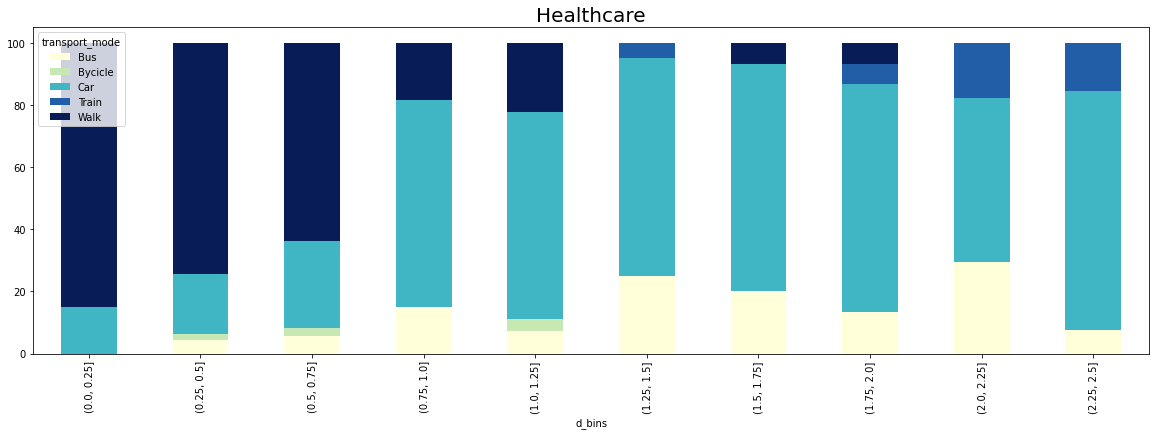

In [ ]:
ax = pivot.plot.bar(cmap="YlGnBu", stacked=True, figsize=(20,6))
ax.set_title('Healthcare', fontsize=20)
#ax.set_ylim(0,500)
#ax.set_xticklabels(['A','B','C'], rotation=0)

In [ ]:
trips_stu.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose,person_id,z_scores_miles,z_scores_time,d_bins
0,30001011,2,30000,30000,U,U,NY,1.357,11,30,18,0,0,Bus,Healthcare,300010112,-0.837007,-0.527280,"(1.25, 1.5]"
1,30006156,3,30000,30000,U,U,PA,6.883,10,45,9,0,0,Bus,Healthcare,300061563,1.071629,-0.114681,NaN


# Logistic regression

In [ ]:
#https://realpython.com/logistic-regression-python/

trips_stu=trips_filt[trips_filt['travel_purpose']=='School']
trips_stu_2=trips_stu[trips_stu['TRPMILES']<1.5].reset_index(drop=True)
cond = {
    'Walk': 1
}

trips_stu_2['binary_walk'] = trips_stu_2['transport_mode'].map(cond).fillna(0)

trips_stu_2.sort_index(axis = 1)
trips_stu_2.head(10)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose,person_id,z_scores_miles,z_scores_time,binary_walk
0,30002153,6,17000,17000,U,U,CA,0.569,3,10,8,2,1,Car,School,300021536,-0.623835,-0.509787,0.0
1,30019981,2,30000,17000,U,U,IL,0.999,4,15,8,1,1,Car,School,300199812,-0.538549,-0.152871,0.0
2,30030006,3,17000,17000,U,U,WA,0.847,3,7,8,1,1,Car,School,300300063,-0.568696,-0.723936,0.0
3,30048591,3,17000,17000,U,U,NY,0.888,4,10,8,1,1,Car,School,300485913,-0.560564,-0.509787,0.0
4,30068943,6,17000,17000,C,C,TX,0.816,3,5,8,3,3,Car,School,300689436,-0.574845,-0.866703,0.0
5,30102880,3,17000,17000,U,U,CA,0.967,5,10,8,5,0,Car,School,301028803,-0.544896,-0.509787,0.0
6,30111376,3,17000,17000,U,U,CA,1.174,3,8,8,1,1,Car,School,301113763,-0.503839,-0.652553,0.0
7,30128354,3,17000,17000,U,U,WI,1.064,3,5,8,3,3,Car,School,301283543,-0.525657,-0.866703,0.0
8,30128354,4,17000,17000,U,U,WI,1.064,3,5,8,3,3,Car,School,301283544,-0.525657,-0.866703,0.0
9,30165692,2,30000,30000,U,U,CA,1.225,3,10,8,1,1,Car,School,301656922,-0.493724,-0.509787,0.0


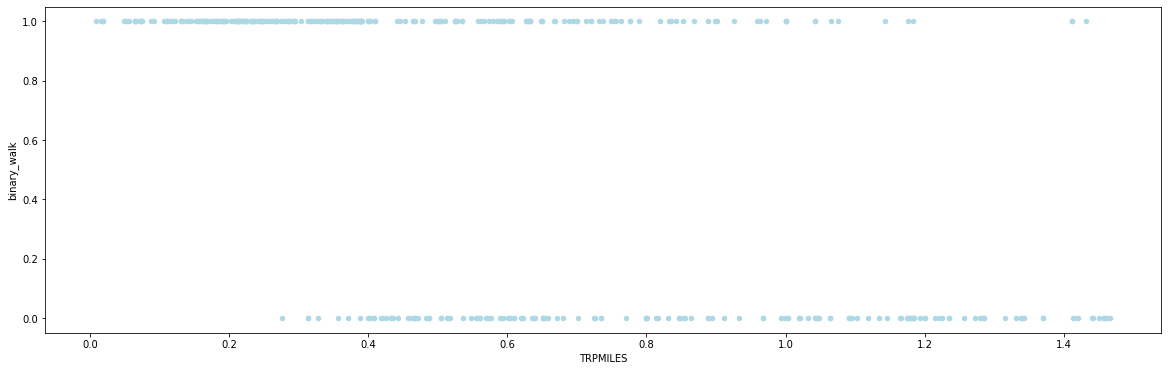

In [ ]:
trips_stu_2.plot.scatter(x='TRPMILES', y='binary_walk', c='LightBlue', figsize=(20,6))
#plt.xlim([0,1.5])
plt.show()

In [ ]:
X = trips_stu_2[['TRPMILES']] # Features
y = trips_stu_2.binary_walk # Target variable
# instantiate the model (using the default parameters)
model = LogisticRegression(solver='liblinear', random_state=0).fit(X, y)

trips_stu_2['probability']=pd.DataFrame(model.predict_proba(X)).iloc[:,1]
trips_stu_2['log_reg']= model.predict(X)
trips_stu_2.head(10)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,DBHUR,OBHUR,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,...,TRPACCMP,TRPHHACC,transport_mode,travel_purpose,person_id,z_scores_miles,z_scores_time,binary_walk,probability,log_reg
0,30002153,6,17000,17000,U,U,CA,0.569,3,10,...,2,1,Car,School,300021536,-0.623835,-0.509787,0.0,0.663049,1.0
1,30019981,2,30000,17000,U,U,IL,0.999,4,15,...,1,1,Car,School,300199812,-0.538549,-0.152871,0.0,0.318003,0.0
2,30030006,3,17000,17000,U,U,WA,0.847,3,7,...,1,1,Car,School,300300063,-0.568696,-0.723936,0.0,0.436843,0.0
3,30048591,3,17000,17000,U,U,NY,0.888,4,10,...,1,1,Car,School,300485913,-0.560564,-0.509787,0.0,0.403411,0.0
4,30068943,6,17000,17000,C,C,TX,0.816,3,5,...,3,3,Car,School,300689436,-0.574845,-0.866703,0.0,0.462526,0.0
5,30102880,3,17000,17000,U,U,CA,0.967,5,10,...,5,0,Car,School,301028803,-0.544896,-0.509787,0.0,0.341682,0.0
6,30111376,3,17000,17000,U,U,CA,1.174,3,8,...,1,1,Car,School,301113763,-0.503839,-0.652553,0.0,0.206041,0.0
7,30128354,3,17000,17000,U,U,WI,1.064,3,5,...,3,3,Car,School,301283543,-0.525657,-0.866703,0.0,0.272769,0.0
8,30128354,4,17000,17000,U,U,WI,1.064,3,5,...,3,3,Car,School,301283544,-0.525657,-0.866703,0.0,0.272769,0.0
9,30165692,2,30000,30000,U,U,CA,1.225,3,10,...,1,1,Car,School,301656922,-0.493724,-0.509787,0.0,0.179501,0.0


In [ ]:
model.score(X,y)

0.7665847665847666

Text(0.5, 257.44, 'Predicted label')

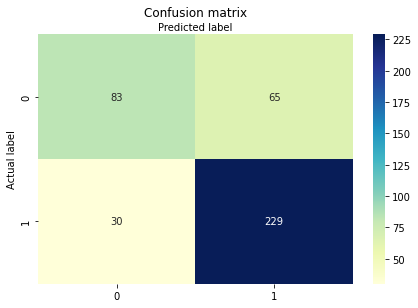

In [ ]:
cm= confusion_matrix(y, model.predict(X))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

         0.0       0.73      0.56      0.64       148
         1.0       0.78      0.88      0.83       259

    accuracy                           0.77       407
   macro avg       0.76      0.72      0.73       407
weighted avg       0.76      0.77      0.76       407



In [ ]:
walking_boundary=trips_stu_2[trips_stu_2['log_reg']==1]['TRPMILES'].max()
walking_boundary

0.771

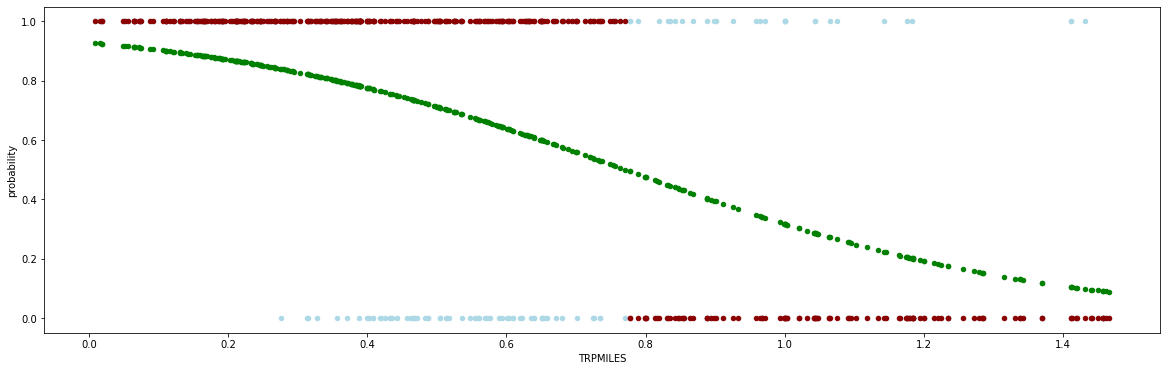

In [ ]:
ax=trips_stu_2.plot.scatter(x='TRPMILES', y='binary_walk', c='LightBlue', figsize=(20,6))
trips_stu_2.plot.scatter(ax=ax, x='TRPMILES', y='log_reg', c='DarkRed', figsize=(20,6))
trips_stu_2.plot.scatter(ax=ax, x='TRPMILES', y='probability', c='Green', figsize=(20,6))
plt.show()

In [ ]:
# Con train y test: https://www.datacamp.com/tutorial/understanding-logistic-regression-python

X = trips_stu_2[['TRPMILES']] # Features
y = trips_stu_2.binary_walk # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)
# instantiate the model (using the default parameters)
model = LogisticRegression(solver='liblinear', random_state=0).fit(X_train, y_train)

y_prop=pd.DataFrame(model.predict_proba(X_test))
y_pred= model.predict(X_test)
model.score(X_test,y_test)

0.8431372549019608

Text(0.5, 257.44, 'Predicted label')

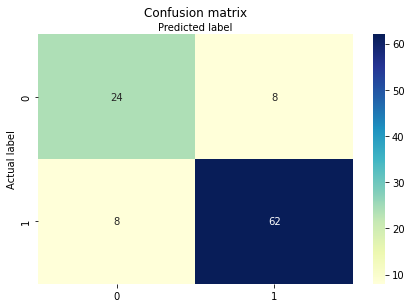

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Explore data

*   EDUC:	Educational Attainment (perpub)
*   R_AGE:	Respondent Age (perpub)
*   HHFAMINC:	Household income
*   HEALTH:	Opinion of Health
*   HHSIZE:	Count of household members
*   HHVEHCNT:	Count of Household vehicles
*   OCCAT:	Job category (perpub)
*   R_SEX:	Gender (perpub)
*   PHYACT:	Level of Physical Activity (perpub)
*   TRAVDAY	Travel day - day of week
*   TRPACCMP	Count of People on Trip (trippub)
*   TRPHHACC	Count of Household Members on Trip (trippub)



In [ ]:
trips.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,TRPACCMP,TRPHHACC,transport_mode,travel_purpose,person_id
0,30000012,1,750,17000,NY,3.395,4,15,16,0,0,Car,Exercise,300000121
1,30000012,1,3000,17000,NY,1.059,4,10,16,0,0,Car,Exercise,300000121


In [ ]:
#Merge HOUSEID and PERSONID
person=perpub[['HOUSEID', 'PERSONID', 'EDUC', 'R_AGE', 'HEALTH', 'HHFAMINC', 'HHSIZE', 'HHVEHCNT', 'OCCAT', 'R_SEX', 'PHYACT', 'TRAVDAY']]
person['person_id'] = person['HOUSEID'].astype(str) + person['PERSONID'].astype(str)
person=person.merge(trips[['person_id', 'TRPMILES', 'TRVLCMIN', 'transport_mode', 'travel_purpose']], how='right', on='person_id')
person.head(2)

<ipython-input-37-a3273376d12e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  person['person_id'] = person['HOUSEID'].astype(str) + person['PERSONID'].astype(str)


,HOUSEID,PERSONID,EDUC,R_AGE,HEALTH,HHFAMINC,HHSIZE,HHVEHCNT,OCCAT,R_SEX,PHYACT,TRAVDAY,person_id,TRPMILES,TRVLCMIN,transport_mode,travel_purpose
0,30000082,2,4,38,2,8,4,2,4,1,2,3,300000822,0.239,5,Walk,Work
1,30000085,1,4,30,3,9,1,2,4,1,2,1,300000851,0.251,5,Walk,Work


In [ ]:
person['person_id'].nunique()

8687

In [ ]:
trips_stu=person[person['TRPMILES']<1.5].reset_index(drop=True)
cond = {'Walk': 1}

trips_stu['binary_walk'] = trips_stu['transport_mode'].map(cond).fillna(0)

trips_stu.sort_index(axis = 1)
trips_stu.head(2)

,HOUSEID,PERSONID,EDUC,R_AGE,HEALTH,HHFAMINC,HHSIZE,HHVEHCNT,OCCAT,R_SEX,PHYACT,TRAVDAY,person_id,TRPMILES,TRVLCMIN,transport_mode,travel_purpose,binary_walk
0,30000012,1,5,45,2,10,1,2,4,2,3,5,300000121,1.059,10,Car,Exercise,0.0
1,30000085,1,4,30,3,9,1,2,4,1,2,1,300000851,0.248,10,Walk,F&B Eatery,1.0


# Normal distribution

In [ ]:
trips_stu_2[trips_stu_2['binary_walk']==1]['TRPMILES'].max()

1.975

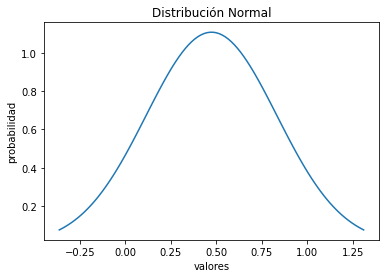

In [ ]:
mean=trips_stu_2[trips_stu_2['transport_mode']=='Walk']['TRPMILES'].mean()
stdev=trips_stu_2[trips_stu_2['transport_mode']=='Walk']['TRPMILES'].std()
normal = stats.norm(mean, stdev)
x = np.linspace(normal.ppf(0.01),
                normal.ppf(0.99), 100)
fp = normal.pdf(x) # Función de Probabilidad
plt.plot(x, fp)
plt.title('Distribución Normal')
plt.ylabel('probabilidad')
plt.xlabel('valores')
plt.show()

In [ ]:
norm.pdf(0.75, loc=mean, scale=stdev)

0.8263409889406432

In [ ]:
trips_stu_3=trips_stu[trips_stu['transport_mode']=='Walk']
trips_stu_3.head(2)

,HOUSEID,PERSONID,DBPPOPDN,OBPPOPDN,HHSTATE,TRPMILES,TRPTRANS,TRVLCMIN,WHYTO,transport_mode,travel_purpose,person_id,z_scores_miles,z_scores_time,d_bins
0,30004211,2,30000,17000,MA,0.195,1,4,18,Walk,Healthcare,300042112,-0.778589,-0.957819,"(0.0, 0.25]"
1,30011599,1,17000,17000,NC,0.303,1,15,18,Walk,Healthcare,300115991,-0.485472,0.066937,"(0.25, 0.5]"


In [ ]:
count_people_2 = trips_stu_3.groupby(['d_bins'])['person_id'].count().to_frame().reset_index().rename(columns = {'person_id': 'count_people'})
count_people_2.head(3)

,d_bins,count_people
0,"(0.0, 0.25]",44
1,"(0.25, 0.5]",41
2,"(0.5, 0.75]",27


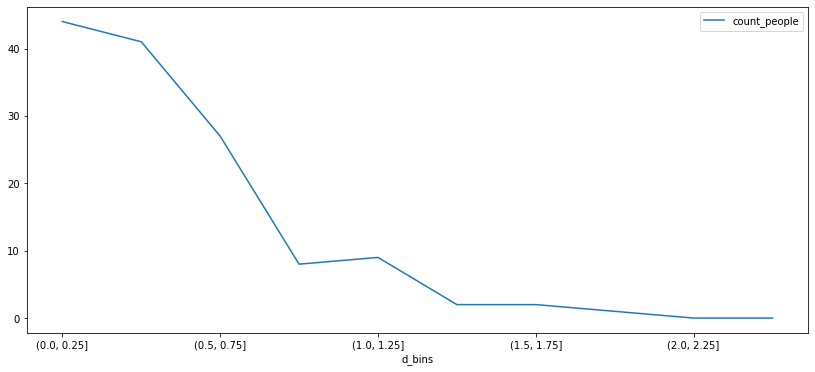

In [ ]:
count_people_2.plot(x='d_bins', y='count_people', kind='line', figsize=(14,6))